In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf 

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    TimeSeriesSplit
)

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

SEED = 42

In [2]:
UX = pd.read_csv('/Users/egor/Desktop/uranium_project/PURANUSDM.csv') # Uranium Price
fed_rate = pd.read_csv('/Users/egor/Desktop/uranium_project/FEDFUNDS.csv') # Fed Rate
brent = pd.read_csv('/Users/egor/Desktop/uranium_project/POILBREUSDM.csv') # Oil
coal = pd.read_csv('/Users/egor/Desktop/uranium_project/PCOALAUUSDM.csv') # Coal
cpi_cum = pd.read_csv('/Users/egor/Desktop/uranium_project/CPIAUCSL.csv') # CPI

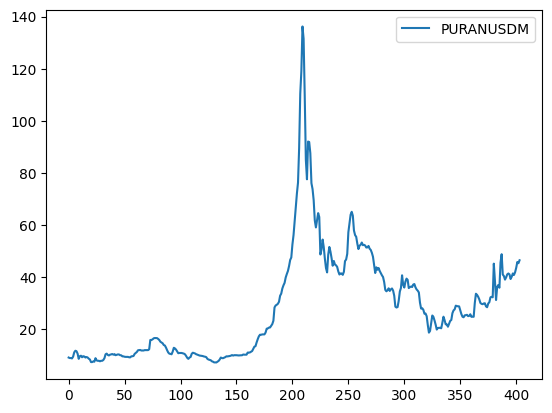

In [3]:
sns.lineplot(data=UX);

In [4]:
coal

,DATE,PCOALAUUSDM
0,1990-01-01,38.000000
1,1990-02-01,38.000000
2,1990-03-01,38.000000
3,1990-04-01,38.000000
4,1990-05-01,40.500000
...,...,...
399,2023-04-01,200.676190
400,2023-05-01,179.262321
401,2023-06-01,138.631656
402,2023-07-01,141.029592


In [5]:

ticker_symbol = "DX-Y.NYB"  # Replace with the symbol of the stock you're interested in

ticker = yf.Ticker(ticker_symbol)

start_date = "1990-01-01"
end_date = "2023-08-31"

historical_data = ticker.history(start=start_date, end=end_date, interval="1mo")

usd_index = historical_data['Close'] # USD Index

usd_index.index = pd.to_datetime(usd_index.index)


In [6]:
df = (
    UX.merge(fed_rate, on = "DATE")
    .merge(brent, on = "DATE")
    .merge(coal, on = "DATE")
    .merge(cpi_cum, on = "DATE")
    .merge(usd_index, on = usd_index.index)
)

col_names = {
    'DATE': 'date',
    'PURANUSDM': 'uranium',
    'FEDFUNDS': 'fed_rate',
    'POILBREUSDM': 'brent',
    'PCOALAUUSDM': 'coal',
    'CPIAUCSL': 'cpi',
    'Close': 'usd_index'
}

df = df.rename(columns=col_names)

df['date'] = pd.to_datetime(df['date'])

del df['key_0']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       404 non-null    datetime64[ns]
 1   uranium    404 non-null    float64       
 2   fed_rate   404 non-null    float64       
 3   brent      404 non-null    float64       
 4   coal       404 non-null    float64       
 5   cpi        404 non-null    float64       
 6   usd_index  404 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 22.2 KB


In [7]:
corr_matrix = df.drop(['date'], axis =1).copy().phik_matrix()
corr_matrix.round(2)

mask = np.triu(np.ones_like(corr_matrix.round(2), dtype=bool))
f, ax = plt.subplots(figsize=(25, 12), dpi = 800)

sns.heatmap(
    corr_matrix.round(2), 
    center=-0.07, 
    cmap="coolwarm", 
    square=True,
    linewidth=0.5, 
    cbar_kws={"shrink": .5}, 
    annot=True, 
    mask=mask
)
ax.set_title('Correlation Matrix');

interval columns not set, guessing: ['uranium', 'fed_rate', 'brent', 'coal', 'cpi', 'usd_index']


In [8]:
train, test = train_test_split(
    df,
    shuffle = False,
    test_size = 0.1,
    random_state = SEED
)

X_train = train.drop(['date', 'uranium'], axis = 1).copy()
y_train = train['uranium'].copy()

X_test = test.drop(['date', 'uranium'], axis = 1).copy()
y_test = test['uranium'].copy()

In [9]:
model_1 = LinearRegression()

model_1.fit(X_train, y_train)

preds_1 = model_1.predict(X_test)

score_1 = mean_squared_error(y_test, preds_1)
score_1


52.108132663665316

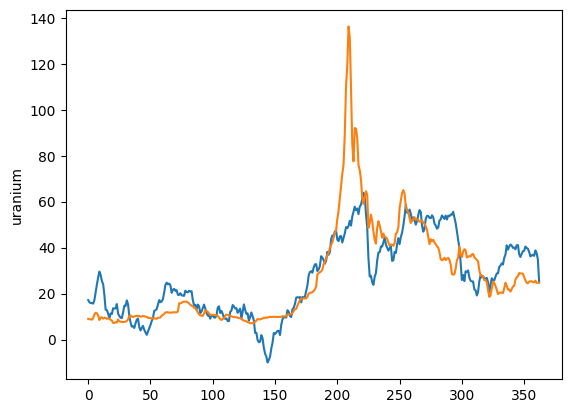

In [10]:
sns.lineplot(data=model_1.predict(X_train))
sns.lineplot(data=y_train);

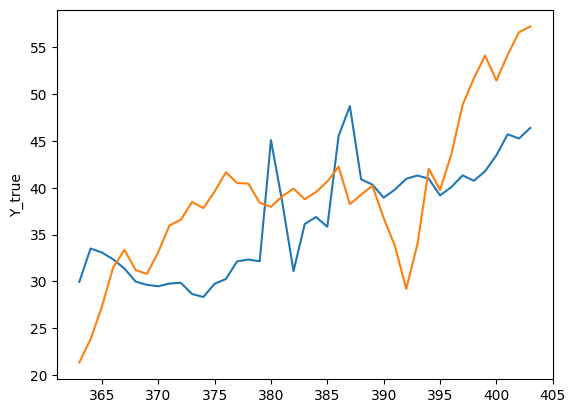

In [11]:
lr_test_data = pd.DataFrame(
    {
        'Y_true': y_test,
        'Y_preds': preds_1
    }
)

sns.lineplot(data=lr_test_data.Y_true)
sns.lineplot(data=lr_test_data.Y_preds);